# CSE151B Project Milestone Code

## Install the package dependencies before running this notebook

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob
import pandas as pd

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

## Create a Torch.Dataset class for the training dataset AND  Create a DataLoader class for training

In [4]:
from glob import glob
import pickle
import numpy as np
from sklearn.preprocessing import normalize 

ROOT_PATH = "./argo2/"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):
    
    outputs = None
    relative_out = None

    if split=="train":
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[:int(n * 0.8)]

        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[:int(n * 0.8)]
        
    elif split == 'val':
        f_in = ROOT_PATH + 'train' + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[int(n * 0.8):]
        
        f_out = ROOT_PATH + 'train' + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[int(n * 0.8):]
    
    elif split == "test":
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)
    
    if normalized:
        
        mean_x = np.mean(inputs[:, :, 0])
        inputs[:, :, 0] = inputs[:, :, 0] / mean_x
        mean_y = np.mean(inputs[:, :, 1])
        inputs[:, :, 1] = inputs[:, :, 1] / mean_y
        
        #outputs = normalize(inputs, axis=1, norm='l1')
    
    #get relative position
    origin = inputs[:,0,:]
    
    new_origin = inputs.copy()
    for j,d in enumerate(new_origin):
        for i,d in enumerate(new_origin[j]):
            new_origin[j][i] = origin[j]
    relative_inp = inputs - new_origin
            
    if outputs is not None:
        new_origin_out = outputs.copy()
        for j,d in enumerate(new_origin_out):
            for i,d in enumerate(new_origin_out[j]):
                new_origin_out[j][i] = origin[j]
        relative_out = outputs - new_origin_out
    
    return relative_inp, relative_out

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform

        self.inputs, self.outputs = [], []
        
        city_one_hot = {"austin": [1, 0, 0, 0, 0, 0], "miami": [0, 1, 0, 0, 0, 0], \
                        "pittsburgh": [0, 0, 1, 0, 0, 0], "dearborn": [0, 0, 0, 1, 0, 0], \
                        "washington-dc": [0, 0, 0, 0, 1, 0], "palo-alto": [0, 0, 0, 0, 0, 1]}
        
        for city in ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]:
            
            inp, out = get_city_trajectories(city=city, split=split, normalized=False)
    
            inp = inp.tolist()
            for i in inp: #one hot encoding for each city
                for j in i:
                    j.extend(city_one_hot[city])
            self.inputs.extend(inp)
                    
            if out is not None:
                out = out.tolist()
                self.outputs.extend(out)
            else:
                self.outputs = None
                
        self.inputs = np.array(self.inputs)
        if self.outputs is not None:
            self.outputs = np.array(self.outputs)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        if self.outputs is None:
            data = self.inputs[idx]
        else:
            data = (self.inputs[idx], self.outputs[idx])
        
        if self.transform:
            data = self.transform(data)

        return data

In [5]:
# intialize a dataset on all just for visualization purpose:\  (around 10 mins)
train_dataset  = ArgoverseDataset(split = 'train')
val_dataset = ArgoverseDataset(split = 'val')

In [6]:
## Create a DataLoader class for training
batch_sz = 4  # batch size 
train_loader = DataLoader(train_dataset,batch_size=batch_sz)
val_loader = DataLoader(val_dataset,batch_size=batch_sz)

## Sample a batch of data and visualize 

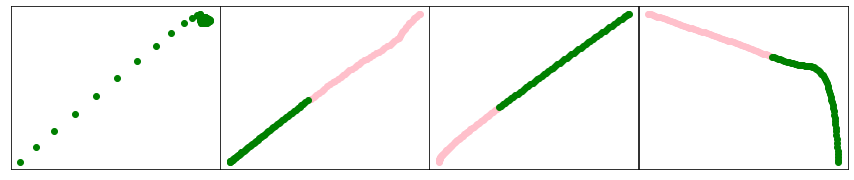

In [7]:
import matplotlib.pyplot as plt
import random


def show_sample_batch(sample_batch):
    """visualize the trajectory for a batch of samples"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i,:,0], inp[i,:,1], color='pink')
        axs[i].scatter(out[i,:,0], out[i,:,1], color='green')


for i_batch, sample_batch in enumerate(train_loader):
    inp, out = sample_batch
    """
    TODO:
      implement your Deep learning model
      implement training routine
    """
    show_sample_batch(sample_batch)
    
    break

# SeqToSeq: MLP Model (linear layers for encoder and decoder)

In [16]:
from torch import nn, optim

class get_output_hidden(nn.Module):
    def forward(self, x):
        out, hidden = x
        return hidden
    
class get_output(nn.Module):
    def forward(self, x):
        out, hidden = x
        return out
    
class Pred(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(

            nn.Linear(400, 240),
            nn.ReLU(),
            nn.Linear(240, 96),
            nn.ReLU(),
            nn.Linear(96, 48),
            nn.ReLU(),
            nn.Linear(48, 16),
            nn.ReLU(),
            nn.Linear(16, 16)
        )

        self.decoder = nn.Sequential(

            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 120),
            nn.ReLU(),
            nn.Linear(120, 120)
        )
        
    def forward(self, x):
        x = x.reshape(-1, 400).float()
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.reshape(-1, 60, 2)
        return x

In [17]:
pred = Pred()
opt = optim.Adam(pred.parameters(), lr=1e-3)

In [18]:
#count trainable parameters
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Pred().to(dev)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("number of parameters", count_parameters(model))

number of parameters 676000


### prepare the dataframe for submission

In [11]:
submission = pd.read_csv('./argo2/sample_submission.csv')
submission = submission.set_index("ID")

In [12]:
submission.head()

,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119
ID,,,,,,,,,,,,,,,,,,,,,
0_austin,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1_austin,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2_austin,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3_austin,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4_austin,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Training the Model:

In [13]:
loss_lis = []

def train_model_everything(train_dataset, val_dataset, train_loader, val_loader):

    # intialize a dataset (for all) - did aready
   
    for epoch in range(10):

        total_loss = 0
        for i_batch, sample_batch in enumerate(train_loader):
            inp, out = sample_batch
            preds_city = pred(inp)
            loss = ((preds_city - out) ** 2).sum()

            opt.zero_grad()
            loss.backward()
            opt.step()

            total_loss += loss.item()
            loss_lis.append(loss.item())

        print('epoch {} training loss: {}'.format(epoch, total_loss / (120 * len(train_dataset))))
    
    
    #VALIDATION
    val_loss = 0
    for i_batch, sample_batch in enumerate(val_loader):
        inp, out = sample_batch
        preds = pred(inp)
        loss = ((preds - out) ** 2).sum()

        val_loss += loss.item()
    print('validation loss: {}'.format(val_loss / (120 * len(val_dataset))))
    

In [14]:
#batch 4 epoch 10 with all data
train_model_everything(train_dataset, val_dataset, train_loader, val_loader)

epoch 0 training loss: 65.18576895832922
epoch 1 training loss: 43.07242600905453
epoch 2 training loss: 37.12295688028823
epoch 3 training loss: 35.071826458119695
epoch 4 training loss: 33.63932988859867
epoch 5 training loss: 32.58145602095177
epoch 6 training loss: 31.71651920758844
epoch 7 training loss: 31.08943124907304
epoch 8 training loss: 30.606444048218663
epoch 9 training loss: 30.237992902469614
validation loss: 34.827689732945295


### Get ground_truth and Prediction for Training

In [75]:
def get_origin(split):
    ROOT_PATH = "./argo2/"
    cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
    all_inputs = []
    
    for city in cities:
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        inputs = inputs.tolist()
        all_inputs.extend(inputs)
    all_inputs = np.asarray(all_inputs)
        
    #get reletive position
    origin = all_inputs[:,0,:]
    return origin

In [105]:
origin_train = get_origin("train")
    
#TRAINING PREDICTION FOR ALL:
prediction_train = []
true_train = []
input_train = []
batch_sz = 1  # batch size 
train_loader_1 = DataLoader(train_dataset, batch_size=batch_sz)
    
for i_batch, sample_batch in enumerate(train_loader_1):
    
    inp, out = sample_batch

    absolute_out = out + torch.from_numpy(origin_train[i_batch])
    input_train.append(inp)
    true_train.append(absolute_out)
    
    p = pred(inp)
    absolute_p = p + torch.from_numpy(origin_train[i_batch])
    prediction_train.append(absolute_p)
    
    

### Get Prediction for Testing and Write to the file

In [136]:
origin_test = get_origin("test")

#TESTING
test_dataset = ArgoverseDataset(split = "test")
batch_sz = 1  # batch size 
test_loader = DataLoader(test_dataset,batch_size=batch_sz)

preds = []
    
for i_batch, sample_batch in enumerate(test_loader):
    inp = sample_batch
    p = pred(inp)
    absolute_p = p + torch.from_numpy(origin_test[i_batch])
    preds.append(absolute_p)

#write to submission dataframe
for i, p in enumerate(preds):
    new_p = p.reshape(-1, 120).float().tolist()[0]
    submission.iloc[i] = new_p
        
print() #print a new line to separate each city's model

In [137]:
submission.head()

,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119
ID,,,,,,,,,,,,,,,,,,,,,
0_austin,-13.197170,-567.461182,-13.943436,-567.213684,-14.708767,-567.014465,-15.428402,-566.776123,-16.228348,-566.386719,...,-51.520248,-553.134644,-52.180084,-552.909302,-52.593910,-552.682922,-52.955719,-552.506042,-53.140617,-552.514221
1_austin,-341.475922,12.494085,-341.139709,11.960777,-340.842957,11.890076,-340.330933,11.522419,-340.076294,10.856440,...,-307.956970,0.147953,-307.371033,-0.035663,-306.751434,0.015560,-306.357330,-0.133236,-306.261322,-0.456531
2_austin,51.484787,-248.085983,51.498783,-248.032440,51.495781,-248.015320,51.504292,-247.973190,51.522717,-247.929062,...,52.235241,-245.121353,52.330936,-245.022278,52.336460,-244.998810,52.352024,-244.961426,52.315811,-244.898972
3_austin,-113.879639,1798.687866,-113.850296,1798.809204,-113.799057,1798.941284,-113.782745,1799.082764,-113.744568,1799.258301,...,-111.244644,1810.416504,-111.254509,1810.629150,-111.211853,1810.793701,-111.150284,1810.944458,-111.089859,1810.998901
4_austin,1196.773438,-639.519592,1197.667725,-639.830261,1198.656860,-640.036133,1199.544922,-640.566223,1200.512817,-640.852783,...,1236.272217,-657.240051,1236.659912,-657.318054,1236.996826,-657.278870,1237.443970,-657.708191,1237.922485,-657.780640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1681_palo-alto,-1392.236572,-483.531311,-1392.957153,-484.720245,-1393.947388,-485.874420,-1394.779053,-487.169586,-1395.779541,-488.475220,...,-1443.771851,-557.686829,-1444.652588,-558.977844,-1445.634521,-560.260986,-1446.024048,-561.237976,-1446.538330,-561.958618
1682_palo-alto,129.059677,-20.664438,128.995743,-20.086493,129.518326,-19.291636,129.976257,-18.320673,130.482605,-17.791887,...,165.607773,26.940935,166.761612,27.516375,167.572357,27.857119,167.541260,28.407656,167.988251,28.659105
1683_palo-alto,-1437.632935,2160.177490,-1437.345337,2159.967041,-1436.974609,2159.636475,-1436.582031,2159.209473,-1436.164551,2158.947021,...,-1405.825073,2137.110596,-1405.127930,2136.800781,-1404.710327,2136.528320,-1404.051514,2136.290283,-1403.849976,2135.872559


### write predictions on test set to csv file 

In [138]:
from pathlib import Path  
filepath = Path('./argo2/out.csv')  
submission.to_csv(filepath)

## randomly choose from training set and plot the ground truth and prediction trajectories

In [139]:
from random import *
def plot_truth_prediction():
    
#     fig, axs = plt.subplots(1,2, figsize=(15, 3), facecolor='w', edgecolor='k')
#     fig.subplots_adjust(hspace = .5, wspace=.001)
#     axs = axs.ravel()  
    
    idx = randint(0, int(163050))
    truth = true_train[idx]
    prediction = prediction_train[idx]
    inp = input_train[idx]

    truth_array = np.array(truth.tolist()[0])
    prediction_array = np.array(prediction.tolist()[0])
    inp_array_x = np.array(inp.tolist()[0])[:, 0] + origin_train[idx][0]
    inp_array_y = np.array(inp.tolist()[0])[:, 1] + origin_train[idx][1]

    plt.scatter(inp_array_x, inp_array_y, color = "pink")
    plt.scatter(truth_array[:,0], truth_array[:,1], color='green')
    plt.scatter(prediction_array[:,0], prediction_array[:,1], color='blue')
    plt.legend(["input" , "output", "prediction"])
    plt.title('Ground_Truth VS Prediction Trajectory')
    

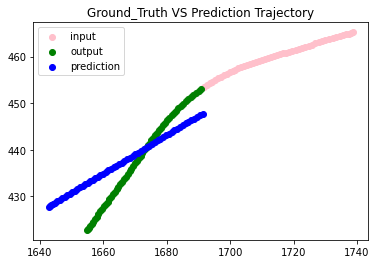

In [149]:
plot_truth_prediction()

## Plot Training Loss over Step

Text(0.5, 1.0, 'MSE Loss')

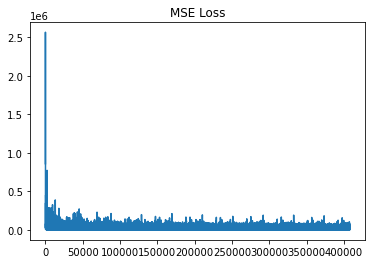

In [15]:
plt.plot(loss_lis)
plt.title("MSE Loss")

old code on writing to submission dataframe and csv file:

In [560]:
### Get the prediction and write to the dataFrame
# def get_pred(city):
#     test_dataset = ArgoverseDataset(city = city, split = "test")
#     batch_sz = 1  # batch size 
#     test_loader = DataLoader(test_dataset,batch_size=batch_sz)
    
#     for i_batch, sample_batch in enumerate(test_loader):
#         inp = sample_batch
        
#     preds = []
#     test_loss = 0
#     for i_batch, sample_batch in enumerate(test_loader):
#         inp = sample_batch
#         preds.append(pred(inp))
        
#     return preds

In [561]:
# submission = pd.read_csv('./argo2/sample_submission.csv')

In [562]:
# submission = submission.set_index("ID")

In [563]:
# cities = ['austin', 'dearborn', 'miami', 'palo-alto', 'pittsburgh', 'washington-dc']

# for city in cities:
#     preds = get_pred(city)
#     for i, p in enumerate(preds):
#         new_p = p.reshape(-1, 120).float().tolist()[0]
#         submission.loc[str(i)+'_'+city] = new_p

In [564]:
# from pathlib import Path  
# filepath = Path('./argo2/out.csv')  
# submission.to_csv(filepath)

# EDA: the distribution of input/output positions for all agents

In [68]:
import seaborn as sns

def get_pivot(city, all_cities=False):
    cities = ['austin', 'dearborn', 'miami', 'palo-alto', 'pittsburgh', 'washington-dc']
    ROOT_PATH = "./argo2/"
    
    all_inputs = []
    all_outputs = []

    def get_data(city):
        
        f_in = ROOT_PATH + "train/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        
        f_out = ROOT_PATH + "train/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        
        #get reletive position
        origin = inputs[:,0,:]

        new_origin = inputs.copy()
        for j,d in enumerate(new_origin):
            for i,d in enumerate(new_origin[j]):
                new_origin[j][i] = origin[j]
        relative_inp = inputs - new_origin

        if outputs is not None:
            new_origin_out = outputs.copy()
            for j,d in enumerate(new_origin_out):
                for i,d in enumerate(new_origin_out[j]):
                    new_origin_out[j][i] = origin[j]
            relative_out = outputs - new_origin_out
        
        all_inputs.extend(relative_inp)
        all_outputs.extend(relative_out)
        

    if all_cities == False:
        get_data(city)
    elif all_cities == True:
        for c in cities:
            get_data(c)
        
    #convert to array
    inputs_array = np.asarray(all_inputs)
    outputs_array = np.asarray(all_outputs)

    #reshape so that its one dim for all cities
    n, t, d = inputs_array.shape
    allTimes_inputs_array = inputs_array.reshape(n*t, d)
    n, t, d = outputs_array.shape
    allTimes_outputs_array = outputs_array.reshape(n*t, d)

    #put x and y in groups
    #and convert the groups back (*100)
    df_input = pd.DataFrame(data=allTimes_inputs_array, columns=['x', 'y'])
    df_input['x_groups'] = 5 * (df_input.x // 5)
    df_input['y_groups'] = 5 * (df_input.y // 5)

    df_output = pd.DataFrame(data=allTimes_outputs_array, columns=['x', 'y'])
    df_output['x_groups'] = 5 * (df_output.x // 5)
    df_output['y_groups'] = 5 * (df_output.y // 5)

    #get the counts for each (x, y) group
    df_input_new = df_input.groupby(['x_groups', 'y_groups']).size()
    df_input_new = pd.DataFrame(df_input_new)

    df_input_new.columns = ['counts']
    df_input_new = df_input_new.reset_index()

    df_output_new = df_output.groupby(['x_groups', 'y_groups']).size()
    df_output_new = pd.DataFrame(df_output_new)
    df_output_new.columns = ['counts']
    df_output_new = df_output_new.reset_index()

    #pivot
    df_input_plot = df_input_new.pivot(index='x_groups', columns='y_groups', values='counts')
    df_output_plot = df_output_new.pivot(index='x_groups', columns='y_groups', values='counts')
    return df_input_plot, df_output_plot
    
def plot_heatmap(city, all_cities=False):
    
    df_input_plot, df_output_plot = get_pivot(city, all_cities)
    
    fig, axes = plt.subplots(ncols=2, figsize=(16, 6))
    fig.subplots_adjust(wspace=.2)
    ax1, ax2 = axes
    
    #heatmap for input & output position
    sns.heatmap(df_input_plot, cmap = "coolwarm", ax = ax1).invert_yaxis()
    ax1.set_title("All input", y=-.3)
    
    sns.heatmap(df_output_plot, cmap = "coolwarm", ax = ax2).invert_yaxis()
    ax2.set_title("All output ", y=-.3)
    plt.show()



In [69]:
#cities = ['austin', 'dearborn', 'miami', 'palo-alto', 'pittsburgh', 'washington-dc']

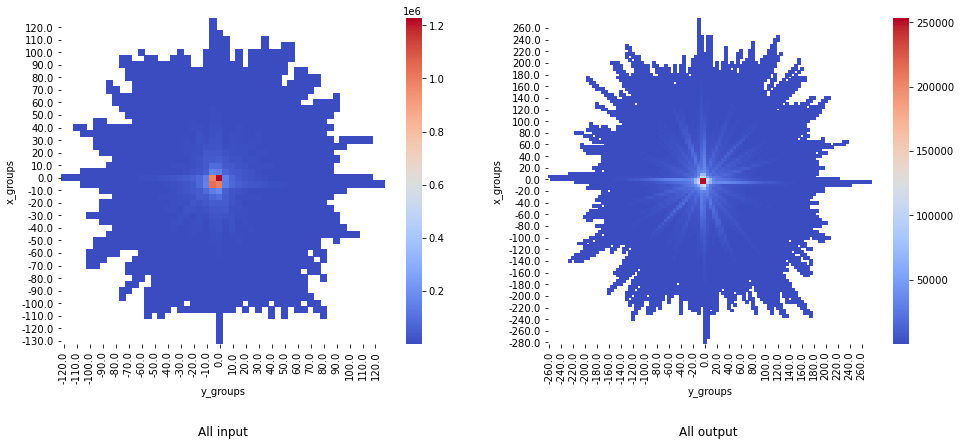

In [77]:
#output the distribution for all cities if True
plot_heatmap('washington-dc', True)

In [26]:
import matplotlib.pyplot as plt
import math
def get_velocity(city, all_cities=False):
    cities = ['austin', 'dearborn', 'miami', 'palo-alto', 'pittsburgh', 'washington-dc']
    ROOT_PATH = "./argo2/"
    
    changes_input = []
    changes_output = []

    def get_data(city):
        
        f_in = ROOT_PATH + "train/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        
        f_out = ROOT_PATH + "train/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        
        for i,d in enumerate(inputs):
            changes_input.append(math.dist(inputs[i,-1,:], inputs[i,0,:])/50)
        for i,d in enumerate(outputs):
            changes_output.append(math.dist(outputs[i,-1,:],outputs[i,0,:])/60)
            
    if all_cities == False:
        get_data(city)
    elif all_cities == True:
        for c in cities:
            get_data(c)
            
    print("average velocity for input", sum(changes_input)/len(changes_input) )
    print("average velocity for output", sum(changes_output)/len(changes_output))
    fig, axes = plt.subplots(ncols=2, figsize=(16, 6))
    fig.subplots_adjust(wspace=.2)
    ax1, ax2 = axes
    
    ax1.hist(changes_input, bins = 50)
    ax1.set_title("velocity for input 50 sec")
    
    ax2.hist(changes_output, bins = 50)
    ax2.set_title("velocity for output 60 sec")
        

average velocity for input 0.5788597403596317
average velocity for output 0.6240154973868006


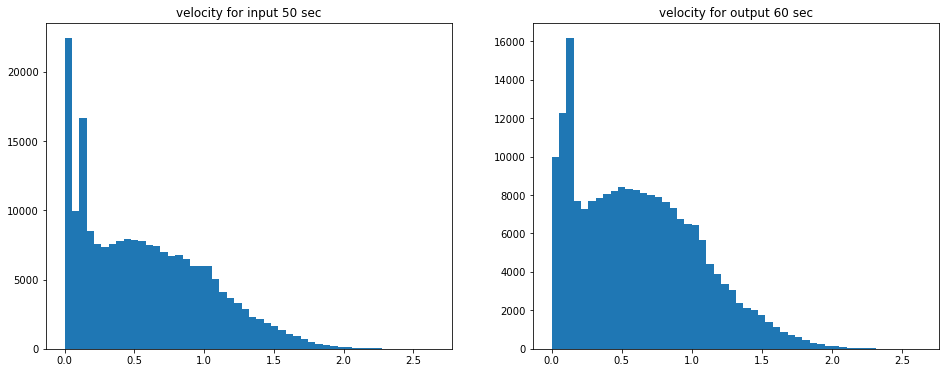

In [27]:
get_velocity("austin", True)

error tracker:

#### starter code: loss: 243130.4356045948

#### add one more linear (32, 16): loss: 234230.23708092162 changed to 356302.6224735306 -> 150056.00799303368 (austin)

#### add one more linear (16, 8): loss: 369038.9848585346

#### add nn.Dropout() at the end: loss: 139978361.54504338

### Model for each city:

#### - 20 epoch and 4 batch: test loss on kaggle 544.36019 - linear layer to 16

city miami validation loss: 98559.84710601612

city pittsburgh validation loss: 25172.430871449083

city dearborn validation loss: 83256.51160414904

city washington-dc validation loss: 59926.98202549418

city palo-alto validation loss: 46965.97407317254

#### - 20 epoch and 64 batch: test loss on kaggle 1113.73683

city austin validation loss: 279558.9845237329

city miami validation loss: 86737.02004293026

city pittsburgh validation loss: 159859.5950301462

city dearborn validation loss: 64473.38859815645

city washington-dc validation loss: 30957.191266277485

city palo-alto validation loss: 73393.81933790389

#### - 25 epoch and 3 batch:

city austin validation loss: 52911.8008622041

city miami validation loss: 88357.98424714322

Tuesday, May 24:
#### - initial normalized try: kaggle score: 23183447.53915
 
#### - 10 epoch 4 batch linear model, normalized on the np.array using mean on x and y for train input only: kaggle: 258629573215727.00000
 
city austin validation loss: 157670.7402768396

city miami validation loss: 1959592.4231443857

city pittsburgh validation loss: 91227.79281190076

city dearborn validation loss: 2523215.6038076165

city washington-dc validation loss: 276523.54118590296

city palo-alto validation loss: 178981.39781201252

#### - 10 epoch 4 batch linear model, normalized on the np.array using mean on x and y for train & test input (kaggle: thousands)

city austin validation loss: 159895.71514608504

city miami validation loss: 2325600.779936006

city pittsburgh validation loss: 96821.91801933691

city dearborn validation loss: 1775521.5025307538

city washington-dc validation loss: 198954.68477373937

city palo-alto validation loss: 148117.14359715945


#### - 10 epoch 4 batch with increasing number in linear layers (3 layers ) Kaggle: 1436.45145

city austin validation loss: 183433.64480003214

city miami validation loss: 386331.1446056165

city pittsburgh validation loss: 29015.535780647027

city dearborn validation loss: 185450.14339038482

city washington-dc validation loss: 45704.22556038866

city palo-alto validation loss: 49480.62240936941


- other pre-processing?
- normalization has worse scores (batch norm?)
- increasing / decreasing num in layer
- city feature? 

Thursday, May 26:
#### fixed loss func: 60 epch Kaggle: 431.85858 (best so far)

#### fixed loss func: all city together 1 epoch: kaggle: 4881

training loss: 3148.764601363746
 
validation loss: 2028.2194615384844

#### all cities together 20 epoch: 1296 train, 924 valid, kaggle 

May 28

#### 40 epoch, 3000 batches Linear Kaggle: 395.99066 (valid: 800)

### relative position: 58 train, 65 valid, 15 epoch, 4 batch